## **Лабораторная работа №2**

### **Cумма элементов вектора**

In [12]:
#Импортируем необходимые библиотеки

import time
import sys
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, int32
from tabulate import tabulate

Задаем количество нитей на блок, количество итераций пересчета вычислений, а так же максимальные и минимальные размеры массивов + шаг увеличения размеров.

In [13]:
TPB = 16                                                                         # Количество нитей в блоке
ITER_COUNT = 8
EPS = sys.float_info.epsilon                                                     # Разница между 1,0 и наименьшим значением больше 1,0, который представляется как число с плавающей запятой

vec_size_min = 1000
vec_size_max = 1000000
vec_size_interval = 100000

Cумма вектора на cpu, просто цикл суммирования элементов массива в переменную.

In [14]:
def cpu_vec_sun(vec):
    result =0
    for i in range(vec.shape[0]):
      result += vec[i]
    return result

Функция вычисления суммы вектора на GPU, каждая нить выполняет 1 вычисление, запись в общую переменную res идет через cuda.atomic.add (единовременно выполняется только одной нитью)

In [15]:
@cuda.jit
def gpu_vec_sum(vec, res):
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    idx = tx + bx * TPB
    if idx < vec.shape[0]:
      cuda.atomic.add(res, 0, vec[idx]) 

Делаем вычисления + собираем информацию по времени выполнения обоих функций, далее собранный массив данных используем для графиков времени выполнения на GPU, CPU, а так же для построения графика ускорения.



В данной функции происходит инициализация данных, пересылка данных между хостом и девайсом, замер времени выполнения параллельного суммирования элементов вектора, а также последовательного варианта программы. После выполнения вычисления на GPU результат отправляется обратно на хост.

NameError: ignored

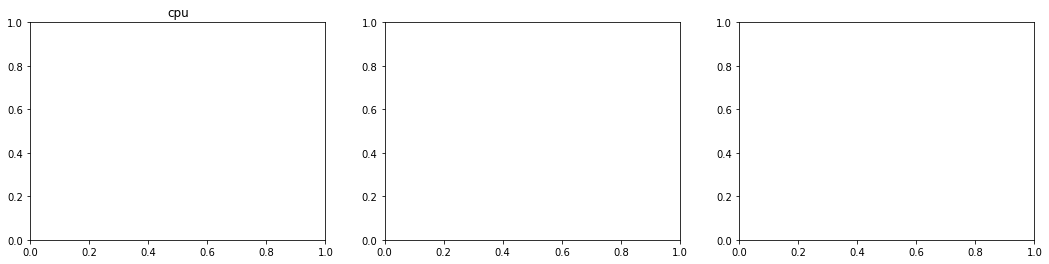

In [22]:
def vector_sum():
    results = [] 
    for vec_size in range(vec_size_min, vec_size_max + 1, vec_size_interval):
        for _ in range(ITER_COUNT):
            # vec = np.random.randint(1000, size=vec_size)
            vec = np.ones(vec_size)
            gpu_result = np.zeros(1, dtype=np.int32)

            device_vec = cuda.to_device(vec)
            device_res = cuda.to_device(gpu_result)
            gpu_start = time.time() 
            gpu_vec_sum[int((vec_size + TPB) / TPB), TPB](device_vec, device_res)
            gpu_time = time.time() - gpu_start
            gpu_result = device_res.copy_to_host()

            cpu_start = time.time()
            cpu_result = cpu_vec_sun(vec)
            cpu_time = time.time() - cpu_start

        result = [vec_size, gpu_result[0], cpu_result, cpu_time / ITER_COUNT, gpu_time / ITER_COUNT]
        results.append(result)

    print(tabulate(results, headers=['vector size', 'resul_gpu', 'resul_cpu', 'cpu, ms', 'gpu, ms']))

    vec_sizes = list(map(lambda x: x[0], results))
    cpu_times = list(map(lambda x: x[2], results))
    gpu_times = list(map(lambda x: x[3], results))
    accelerations = list(map(lambda x: x[2] / (x[3] if x[3] > EPS else EPS), results))


# Теперь построим графики ускорения на GPU относительно СPU

fig, axes = plt.subplots(1, 3, figsize = (18,4))
  
axes[0].set_title("cpu")
axes[0].plot(vec_sizes, cpu_times)
axes[0].set_xlabel("vector size")
axes[0].set_ylabel("time, ms")
axes[0].grid()

axes[1].set_title("gpu")
axes[1].plot(vec_sizes, gpu_times)
axes[1].set_xlabel("vector size")
axes[1].set_ylabel("time, ms")
axes[1].grid()

axes[2].set_title("acceleration")
axes[2].set_plot(vec_sizes, accelerations)
axes[2].set_xlabel("vector size")
axes[2].set_ylabel("cpu to gpu time ratio")
axes[2].grid()

plt.show()